In [ ]:
pip install visualkeras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.applications.vgg16 import preprocess_input,VGG16
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,EarlyStopping
import visualkeras
from PIL import ImageFont

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
seed_constant = 27
random.seed(seed_constant)

In [ ]:
img_dir = ""

#all image names
all_img_names=os.listdir(img_dir)

In [ ]:
len(all_img_names)

23898

In [ ]:
random_range = random.sample(range(len(all_img_names)), 5)
print(random_range)

[21249, 15724, 22982, 9083, 9370]


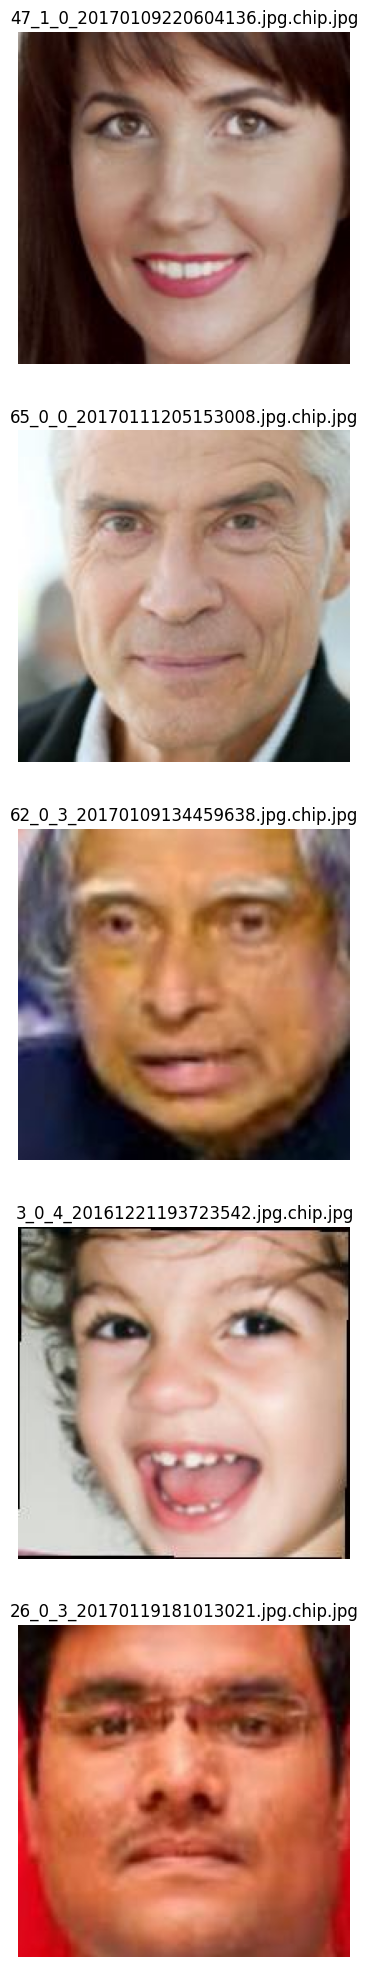

In [ ]:
# Create a Matplotlib figure.
plt.figure(figsize=(25,25))

# Generate a list of 5 random values. The values should be less than number of images in dataset.
random_range = random.sample(range(len(all_img_names)), 5)

#Iterate through random values
for counter, random_index in enumerate(random_range, 1):

    #Name of the selected image
    img_name=all_img_names[random_index]

    #Path of the selected image
    img_path=os.path.join(img_dir,img_name)

    #Read the selected image in BGR format
    bgr_img=cv2.imread(img_path)

    #Convert it into RGB format
    rgb_img=cv2.cvtColor(bgr_img,cv2.COLOR_BGR2RGB)


    #Display the selected image
    plt.subplot(5, 1, counter)
    plt.imshow(rgb_img)
    plt.title(img_name)
    plt.axis('off')

In [ ]:
img_height=224
img_width=224

In [ ]:
def image_preprocessing(img_path):
    img = cv2.imread(img_path)

    # Resize the image
    resized_img = cv2.resize(img, (img_height, img_width))

    # Normalize the image and convert to float32
    normalized_img = resized_img.astype('float32') / 255.0

    return normalized_img


In [ ]:

def label_extraction(img_name):
 '''
 This function will extract age from image name and return the class index by performing integer division (by 25).
 Args:
 img_name: The name of the image.
 Returns:
 class_index: An integer representing the age class.
 '''
 #Extract age
 age=int(img_name.split('_')[0])
 #Class index dividing by 25
 class_index=age//25
 return class_index

In [ ]:
def create_dataset():


 '''
 This function will create the dataset.
 Returns:
 features: A list containing the preprocessed images.
 labels: A list containing the class indexes.
 '''


 #Declare empty lists to store features and labels.

 features=[]
 labels=[]
 img_dir = '/kaggle/input/utkface-new/UTKFace'
 for img_name in all_img_names:

   #Path of the image
   img_path=os.path.join(img_dir,img_name)

   #Get the preprocessed image
   preprocessed_img=image_preprocessing(img_path)

   #Get the class index
   class_index=label_extraction(img_name)

   #Append data into appropriate lists
   features.append(preprocessed_img)
   labels.append(class_index)


 #Convert lists to numpy arrays
 features=np.asarray(features)
 labels=np.asarray(labels)

 return features,labels

In [ ]:
import os
import cv2
import numpy as np

img_dir = "/kaggle/input/utkface-new/UTKFace"

# List all image filenames in the directory
all_img_names = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Select 8000 random images
num_images = 15000
selected_img_names = random.sample(all_img_names, min(num_images, len(all_img_names)))

# Generator function to load images in batches
def data_generator(img_dir, img_names, batch_size=32):
    num_batches = len(img_names) // batch_size
    while True:  # Loop indefinitely (useful for model training)
        for i in range(num_batches):
            batch_img_names = img_names[i * batch_size:(i + 1) * batch_size]
            batch_features = []
            batch_labels = []

            for img_name in batch_img_names:
                img_path = os.path.join(img_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # Resize image
                img = img.astype('float32') / 255.0  # Normalize
                batch_features.append(img)

                # Extract label (modify this according to your logic)
                label = label_extraction(img_name)
                batch_labels.append(label)

            yield np.array(batch_features), np.array(batch_labels)

# Example of using the generator
batch_size = 64
train_generator = data_generator(img_dir, selected_img_names, batch_size)

# Get one batch of data
features, labels = next(train_generator)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)

In [ ]:
encoded_labels=to_categorical(labels)

In [ ]:
# Split the Data into Train ( 90% ) and Test Set ( 10% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, encoded_labels,test_size = 0.2, shuffle = True,random_state = seed_constant)

In [ ]:
#add preprocessing layer at the front of VGG16
vgg = VGG16(input_shape=features_train.shape[1:], weights='imagenet', include_top=False)

#Prevent training already trained layers
for layer in vgg.layers:
    layer.trainable = False

#for layer in vgg.layers[-4:]:  # Unfreeze the last 4 layers
 #   layer.trainable = True

#Add flatten layer
x = Flatten()(vgg.output)

#More Dense layers

#Use weight regularization(L2 vector norm) and dropout layers to reduce overfitting
x=Dense(1000,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

x=Dense(256,activation="relu",kernel_regularizer=l2(0.001))(x)
x=Dropout(0.5)(x)

#Dense layer with number of nuerons equals to number of classes.
prediction = Dense(labels_train.shape[1], activation='softmax')(x)

#Create the model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# checkpointeights
filepath = "C:/Users/Rutvik Rathva/Downloads/vgg16_weights_best_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#Callbacks
callbacks_list=[early_stopping_callback,checkpoint]

# Compile the model and specify loss function, optimizer and metrics values to the model
model.compile(loss = 'categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics = ["accuracy"])

# Start training the model.
history = model.fit(x = features_train, y = labels_train, epochs =75, shuffle = True, validation_split = 0.1, callbacks = callbacks_list )

In [ ]:
import shutil

total, used, free = shutil.disk_usage("/")
print(f"Free space: {free // (2**30)} GiB")

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)